# Bayesian Logistic Regression

In [95]:
include("julia/bayes_logreg.jl");
include("julia/optimization.jl");
using CSV;
using DataFrames;
df = CSV.read("data/cats_dogs.csv", DataFrame);
rename!(df, [:V1, :V2] .=> [:x_1, :x_2]);

For plotting we will use the R package `ggplot2` which can be readily integrated into Julia (just like many other R packages, see for example [here](https://avt.im/blog/2018/03/23/R-packages-ggplot-in-julia#fn:rcall))

In [96]:
using RCall
@rlibrary ggplot2
p = ggplot() +
  scale_color_discrete(name="Labels:") +
  theme_bw();

In [97]:
y = df[:,:y];
N = length(y);
X = Matrix(df[:,Not(:y)]);
X = [ones(N) X]; # add for constant
d = size(X)[2]; # number of features
σ = [1e-5, 1, 100, Inf]; # prior uncertainty
w_0 = zeros(d);

In [98]:
features = DataFrame()
estimates = DataFrame()
for i=1:length(σ)
    H_0 = UniformScaling(1/(σ[i]^2));
    model = bayes_logreg(X,y,w_0,H_0,nll,∇,∇∇);
    w_map = model.μ;
    y_probit = posterior_predictive(model, hcat(ones(N_grid), W));
    estimate = DataFrame(hcat(y_probit,W), :auto);
    insertcols!(estimate, 4, :noise => σ[i])
    estimates = vcat(estimates, estimate)
    feature = copy(df)
    insertcols!(feature, :noise => σ[i])
    features = vcat(features, feature)
end

In [99]:
step = 1;
W = expandgrid((minimum(df.x_1)-50):step:(maximum(df.x_1)+50),(minimum(df.x_2)-50):step:(maximum(df.x_2)+50));
N_grid = size(W)[1];

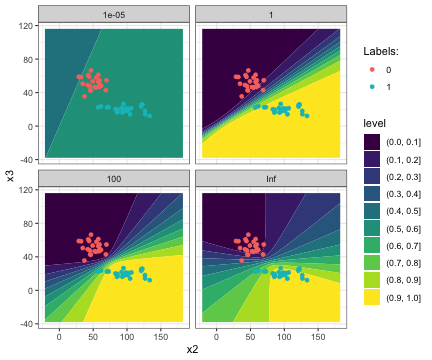

RObject{VecSxp}


In [100]:
p = p + 
  geom_contour_filled(data=estimates, aes(x = :x2, y = :x3, z = :x1), bins=10) +
  geom_point(data=features, aes(x=:x_1, y=:x_2, color=R"factor($features$y)")) +
  facet_wrap(R"~noise")